In [1]:
# 'local[*]' - instructing to use all the cores (*) on a local machine
# 'appName' - will be given a random name unless specified, like Docker container image name
from pyspark.sql import SparkSession


spark = SparkSession.builder. \
        master('local[*]').\
        appName('credit risk').\
        getOrCreate()

In [2]:
# Data source CSV file must reside in the same folder
# The 'german.data-numeric' file delimits columns with 2 spaces ('  ')
#   Without data scrubbing, "IllegalArgumentException: 'Delimiter cannot be more than one character:   '"
df = spark.read.csv('german.data',sep=' ',inferSchema=False,header=False)

In [3]:
PRINT_ROW_NUM = 3
COL_TOTAL_NUM = len(df.columns)

print((df.count(),COL_TOTAL_NUM))
df.printSchema()
df.show(PRINT_ROW_NUM)

(1000, 21)
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)

+---+---+---+---+----+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+
|_c0|_c1|_c2|_c3| _c4|_c5|_c6|_c7|_c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|
+---+---+---+---+----+---+---+---+---+-

All the columns with numbers are "**ordinal**" i.e., the magnitude in each column/feature means "something" (e.g., age, duration, credit amount and installment rate). Thus, **transformation** and **encoding** is NOT needed and they will be converted to non-string.

In [4]:
from pyspark.sql.types import ShortType # a signed 16-bit integer vs. IntegerType (a signed 32-bit integer)

col_indices_of_ordinal_numbers = [2, 5, 8, 11, 13, 16, 18] # Ignore the target/label column i.e., '_c20', the last column
col_indices_of_categorical_numbers = []

def convert_integer_to_string_in_list(aList: list) -> list:
    return [str(item) for item in aList]

for col_idx in range(1, COL_TOTAL_NUM):
    if col_idx not in col_indices_of_ordinal_numbers:
        col_indices_of_categorical_numbers.append(col_idx)

for col_name in df.schema.names:
    # change the name of each column e.g., "_c0" -> "1"
    new_col_num = int(col_name.replace('_c', '')) + 1
    df = df.withColumnRenamed(col_name, str(new_col_num))
    
    if new_col_num in col_indices_of_ordinal_numbers:  
        df = df.withColumn(str(new_col_num), df[str(new_col_num)].cast(ShortType()))
        
col_indices_of_ordinal_numbers = convert_integer_to_string_in_list(col_indices_of_ordinal_numbers)
col_indices_of_categorical_numbers = convert_integer_to_string_in_list(col_indices_of_categorical_numbers)

In [5]:
df.show(PRINT_ROW_NUM)
df.dtypes

+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+
|  1|  2|  3|  4|   5|  6|  7|  8|  9|  10| 11|  12| 13|  14|  15| 16|  17| 18|  19|  20| 21|
+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+
|A11|  6|A34|A43|1169|A65|A75|  4|A93|A101|  4|A121| 67|A143|A152|  2|A173|  1|A192|A201|  1|
|A12| 48|A32|A43|5951|A61|A73|  2|A92|A101|  2|A121| 22|A143|A152|  1|A173|  1|A191|A201|  2|
|A14| 12|A34|A46|2096|A61|A74|  2|A93|A101|  3|A121| 49|A143|A152|  1|A172|  2|A191|A201|  1|
+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+
only showing top 3 rows



[('1', 'string'),
 ('2', 'smallint'),
 ('3', 'string'),
 ('4', 'string'),
 ('5', 'smallint'),
 ('6', 'string'),
 ('7', 'string'),
 ('8', 'smallint'),
 ('9', 'string'),
 ('10', 'string'),
 ('11', 'smallint'),
 ('12', 'string'),
 ('13', 'smallint'),
 ('14', 'string'),
 ('15', 'string'),
 ('16', 'smallint'),
 ('17', 'string'),
 ('18', 'smallint'),
 ('19', 'string'),
 ('20', 'string'),
 ('21', 'string')]

**Databricks**, the leading crowd platform for massive scale data engineering and collaborative data science with optimized Apache Spark™ clusters on AWS or Azure, just pubslihed articles [here](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/5703650563260092/2738738457173388/3024994340111770/latest.html) and [there](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/7274796508260238/2844662950865680/2879908466733289/latest.html) on Apache Spark MLlib Pipelines API. Let's try that.

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler

COL_SUFFIX_IDX = "_INDEX"
COL_SUFFIX_VEC = "_VEC"

stages = []

for col_idx in col_indices_of_categorical_numbers:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=col_idx, outputCol=col_idx + COL_SUFFIX_IDX)
    
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col_idx + COL_SUFFIX_VEC])
    
    # Add stages.  These are not run here, but will run all at once later on.
    stages += [stringIndexer, encoder]

In [7]:
LABEL_COL_NAME = "label"

label_stringIdx = StringIndexer(inputCol=str(COL_TOTAL_NUM), outputCol=LABEL_COL_NAME)
stages += [label_stringIdx]

In [8]:
# Transform all features into a vector using VectorAssembler
FEATURE_VECTOR_COL_NAME = "features"

assemblerInputs = [col_idx + COL_SUFFIX_IDX for col_idx in col_indices_of_categorical_numbers] + col_indices_of_ordinal_numbers
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol=FEATURE_VECTOR_COL_NAME)
stages += [assembler]

In [9]:
from pyspark.ml.feature import StandardScaler

STANDARDIZED_FEATURES_COL_NAME = 'std_features'

standardScaler = StandardScaler(withMean=True, withStd=True, inputCol=FEATURE_VECTOR_COL_NAME, outputCol=STANDARDIZED_FEATURES_COL_NAME)
stages += [standardScaler]

In [11]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
df_pipeline = pipelineModel.transform(df)

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  # F1
  print("F1 = {}".format(multi_metrics.fMeasure()))
  # Precision
  print("Precision = {}".format(multi_metrics.precision()))
  # Recall
  print("Recall = {}".format(multi_metrics.recall()))
  # FPR
  print("FPR = {}".format(multi_metrics.falsePositiveRate(0.0)))
  # TPR
  print("TPR = {}".format(multi_metrics.truePositiveRate(0.0)))

In [19]:
import numpy as np
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression

PCA_FEATURES_COL_NAME = "pca_features"
MAX_ITER_NUM = 50


PCA_feature_num_list = np.arange(1, COL_TOTAL_NUM, 1)
PCA_explainedVariances_list = []
#cumulative_explained_variance = 0

for PCA_feature_num in PCA_feature_num_list:
    PCA_extracted = PCA(k=PCA_feature_num, inputCol=STANDARDIZED_FEATURES_COL_NAME, outputCol=PCA_FEATURES_COL_NAME)

    pca_model = PCA_extracted.fit(df_pipeline)
    df_PCA = pca_model.transform(df_pipeline)

    df_train, df_test = df_PCA.randomSplit([0.7, 0.3], seed = 100)
    
    LR = LogisticRegression(labelCol=LABEL_COL_NAME, featuresCol=PCA_FEATURES_COL_NAME, maxIter=MAX_ITER_NUM)
    LR_model = LR.fit(df_train)
    LR_preds = LR_model.transform(df_test) # Scikit-Learn uses predict() method for prediction

#     print(pca_model.explainedVariance) [0.11832168009876139,0.08249816430977125,0.07512312765618046]
#     print(np.cumsum(pca_model.explainedVariance)) [0.11832168 0.20081984 0.27594297]

    cumulative_explained_variance = np.cumsum(pca_model.explainedVariance)[PCA_feature_num - 1]

    PCA_explainedVariances_list.append(cumulative_explained_variance)
    print(str(PCA_feature_num) + ": " + str(cumulative_explained_variance))

#     LR_preds.select(LABEL_COL_NAME, "prediction", "rawPrediction", "probability").show(PRINT_ROW_NUM)
#     print_performance_metrics(LR_preds)

1: 0.11832168009876139
2: 0.20081984440853262
3: 0.2759429720647131
4: 0.3434691583369005
5: 0.4068048276404337
6: 0.4646192825677727
7: 0.5212579515868058
8: 0.5726833221543236
9: 0.620595299353551
10: 0.66634309561251
11: 0.71070821099644
12: 0.7534198111210798
13: 0.7946167029948367
14: 0.8334120028543393
15: 0.8697509575845473
16: 0.9040447458263459
17: 0.936440526700285
18: 0.9657619466572893
19: 0.9871407977706779
20: 1.0000000000000002


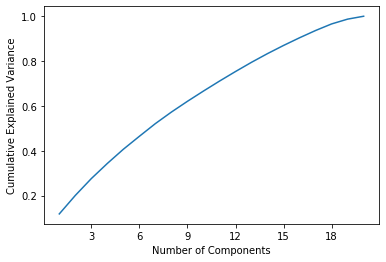

In [20]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

ax = plt.figure().gca()
ax.plot(PCA_feature_num_list, PCA_explainedVariances_list)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

It's pretty apparent that ALL the features should be used in making prediction, as each component noteciably adds variance in relation to the total variance - almost in a straight-line fashion.

In [28]:
MAX_ITER_NUM = 50

In [39]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import NaiveBayes

PARAMETER_CHOICE_NUM = 3
classification_model_and_paramgrid_list = []

LR = LogisticRegression(labelCol=LABEL_COL_NAME, featuresCol=STANDARDIZED_FEATURES_COL_NAME) # , maxIter=MAX_ITER_NUM)
LR_paramGrid = (ParamGridBuilder()
             .addGrid(LR.regParam, np.linspace(0.01, 2, PARAMETER_CHOICE_NUM))
             .addGrid(LR.elasticNetParam, np.linspace(0, 1, PARAMETER_CHOICE_NUM))
             .addGrid(LR.maxIter, np.linspace(1, MAX_ITER_NUM, PARAMETER_CHOICE_NUM, dtype = int))
             .build())
classification_model_and_paramgrid_list.append([LR, LR_paramGrid])


RF = RandomForestClassifier(labelCol=LABEL_COL_NAME, featuresCol=STANDARDIZED_FEATURES_COL_NAME)
RF_ParamGrid = (ParamGridBuilder()
             .addGrid(RF.numTrees, np.linspace(1, MAX_ITER_NUM, PARAMETER_CHOICE_NUM, dtype = int))
             .addGrid(RF.maxDepth, np.linspace(1, COL_TOTAL_NUM, PARAMETER_CHOICE_NUM))
             .build())
classification_model_and_paramgrid_list.append([RF, RF_ParamGrid])


GB = GBTClassifier(labelCol=LABEL_COL_NAME, featuresCol=STANDARDIZED_FEATURES_COL_NAME) #, maxIter=MAX_ITER_NUM)
GB_ParamGrid = (ParamGridBuilder()
             .addGrid(GB.maxIter, np.linspace(1, MAX_ITER_NUM, PARAMETER_CHOICE_NUM, dtype = int))
             .addGrid(GB.maxDepth, np.linspace(1, COL_TOTAL_NUM, PARAMETER_CHOICE_NUM))
             .build())
classification_model_and_paramgrid_list.append([GB, GB_ParamGrid])


LSVC = LinearSVC(maxIter=MAX_ITER_NUM)
LSVC_paramGrid = (ParamGridBuilder()
             .addGrid(LSVC.regParam, np.linspace(0.01, 2, PARAMETER_CHOICE_NUM))
             .addGrid(LSVC.maxIter, np.linspace(1, MAX_ITER_NUM, PARAMETER_CHOICE_NUM, dtype = int))
             .build())
classification_model_and_paramgrid_list.append([LSVC, LSVC_paramGrid])


# OVR = OneVsRest(classifier=LR)
# OVR_paramGrid = (ParamGridBuilder().build())
# classification_model_and_paramgrid_list.append([OVR, OVR_paramGrid])
# IllegalArgumentException: 'Field "rawPrediction" does not exist.\nAvailable fields: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1_INDEX, 1_VEC, 3_INDEX, 3_VEC, 4_INDEX, 4_VEC, 6_INDEX, 6_VEC, 7_INDEX, 7_VEC, 9_INDEX, 9_VEC, 10_INDEX, 10_VEC, 12_INDEX, 12_VEC, 14_INDEX, 14_VEC, 15_INDEX, 15_VEC, 17_INDEX, 17_VEC, 19_INDEX, 19_VEC, 20_INDEX, 20_VEC, label, features, std_features, pca_features, CrossValidator_01aa8f348031_rand, prediction'    

NB = NaiveBayes()
NB_paramGrid = (ParamGridBuilder()
             .addGrid(NB.smoothing, np.linspace(0, 1, PARAMETER_CHOICE_NUM))
             .build())
classification_model_and_paramgrid_list.append([NB, NB_paramGrid])

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

evaluator = BinaryClassificationEvaluator()

for classification_model in classification_model_and_paramgrid_list:
#     # Train model with Training Data
#     model = classification_model.fit(df_train)

#     # Make predictions on test data using the Transformer.transform() method.
#     predictions = model.transform(df_test)

#     # Evaluate model
#     evaluator = BinaryClassificationEvaluator()
#     evaluator.evaluate(predictions)
#     # evaluator.getMetricName() # By default, areaUnderROC

    # Create 5-fold CrossValidator
    cv = CrossValidator(estimator=classification_model[0], 
                        estimatorParamMaps=classification_model[1],
                        evaluator=evaluator,
                        numFolds=5)

    # Run cross validations
    cvModel = cv.fit(df_train)
    # this will likely take a fair amount of time because of the amount of models that we're creating and testing

    # Use test set to measure the accuracy of our model on new data
    predictions = cvModel.transform(df_test)

    # cvModel uses the best model found from the Cross Validation
    # Evaluate best model
    
    print(evaluator.evaluate(predictions))
    
    model_details_in_list = classification_model_and_paramgrid_list[classification_model_and_paramgrid_list.index(classification_model)]
    
    model_details_in_list.append(evaluator.evaluate(predictions))
    model_details_in_list.append(cvModel.bestModel)
    
    print(classification_model_and_paramgrid_list)


0.7225377876191389
0.7742851641474918


In [ ]:
classification_model_and_paramgrid_list

In [42]:
# Standardise the data by scaling the features to have zero mean and unit standard deviation
from pyspark.ml.feature import StandardScaler

STANDARDIZED_FEATURES_COL_NAME = 'std_features'

standardScaler = StandardScaler(withMean=True, withStd=True, inputCol=FEATURE_VECTOR_COL_NAME, outputCol=STANDARDIZED_FEATURES_COL_NAME)
standardScaler_model = standardScaler.fit(df_pipeline)
df_final_standardized = standardScaler_model.transform(df_pipeline)
df_final_standardized.show(PRINT_ROW_NUM)

+-----+--------------------+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+--------------------+
|label|            features|  1|  2|  3|  4|   5|  6|  7|  8|  9|  10| 11|  12| 13|  14|  15| 16|  17| 18|  19|  20| 21|        std_features|
+-----+--------------------+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+--------------------+
|  0.0|[1.0,1.0,0.0,1.0,...|A11|  6|A34|A43|1169|A65|A75|  4|A93|A101|  4|A121| 67|A143|A152|  2|A173|  1|A192|A201|  1|[-0.0010448944788...|
|  1.0|(20,[0,5,7,13,14,...|A12| 48|A32|A43|5951|A61|A73|  2|A92|A101|  2|A121| 22|A143|A152|  1|A173|  1|A191|A201|  2|[1.04384958436457...|
|  0.0|(20,[1,2,4,7,10,1...|A14| 12|A34|A46|2096|A61|A74|  2|A93|A101|  3|A121| 49|A143|A152|  1|A172|  2|A191|A201|  1|[-1.0459393733222...|
+-----+--------------------+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+--------------------+
only s

In [10]:
from pyspark.ml.feature import PCA


#RAW_FEATURES = "raw_feasures"
PCA_FEATURES_COL_NAME = "pca_features"
PCA_FEATURES_NUM = int(COL_TOTAL_NUM / 2)

#df_pca = spark.createDataFrame(features_in_densevector,[RAW_FEATURES])
#type(df_pca) # <class 'pyspark.sql.dataframe.DataFrame'>
#df_pca.printSchema()
PCA_extracted = PCA(k=PCA_FEATURES_NUM, inputCol=STANDARDIZED_FEATURES_COL_NAME, outputCol=PCA_FEATURES_COL_NAME)

stages += [PCA_extracted]

In [11]:
# Run the stages as a Pipeline.
# This puts the data through all of the feature transformations we described in a single call.
  
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
df_pipeline = pipelineModel.transform(df)

In [12]:
df_train, df_test = df_pipeline.randomSplit([0.7, 0.3], seed = 100)
print (df_train.count())
print (df_test.count())

685
315


In [24]:
### IS THIS NECESSARY?????

# # Keep relevant columns 
# # label column is the transformation of Income
# # Features are the numberical representation of all the data numerical+categorical. 
# selected_cols = [LABEL_COL_NAME, FEATURE_VECTOR_COL_NAME] + df.columns
# df_pipeline = df_pipeline.select(selected_cols)
# df_pipeline.show(PRINT_ROW_NUM)

DataFrame[label: double, features: vector, 1: string, 2: smallint, 3: string, 4: string, 5: smallint, 6: string, 7: string, 8: smallint, 9: string, 10: string, 11: smallint, 12: string, 13: smallint, 14: string, 15: string, 16: smallint, 17: string, 18: smallint, 19: string, 20: string, 21: string]

In [42]:
# Standardise the data by scaling the features to have zero mean and unit standard deviation
from pyspark.ml.feature import StandardScaler

STANDARDIZED_FEATURES_COL_NAME = 'std_features'

standardScaler = StandardScaler(withMean=True, withStd=True, inputCol=FEATURE_VECTOR_COL_NAME, outputCol=STANDARDIZED_FEATURES_COL_NAME)
standardScaler_model = standardScaler.fit(df_pipeline)
df_final_standardized = standardScaler_model.transform(df_pipeline)
df_final_standardized.show(PRINT_ROW_NUM)

+-----+--------------------+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+--------------------+
|label|            features|  1|  2|  3|  4|   5|  6|  7|  8|  9|  10| 11|  12| 13|  14|  15| 16|  17| 18|  19|  20| 21|        std_features|
+-----+--------------------+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+--------------------+
|  0.0|[1.0,1.0,0.0,1.0,...|A11|  6|A34|A43|1169|A65|A75|  4|A93|A101|  4|A121| 67|A143|A152|  2|A173|  1|A192|A201|  1|[-0.0010448944788...|
|  1.0|(20,[0,5,7,13,14,...|A12| 48|A32|A43|5951|A61|A73|  2|A92|A101|  2|A121| 22|A143|A152|  1|A173|  1|A191|A201|  2|[1.04384958436457...|
|  0.0|(20,[1,2,4,7,10,1...|A14| 12|A34|A46|2096|A61|A74|  2|A93|A101|  3|A121| 49|A143|A152|  1|A172|  2|A191|A201|  1|[-1.0459393733222...|
+-----+--------------------+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+--------------------+
only s

In [44]:
# Randomly split data into training and test sets. set seed for reproducibility
# Simialr to sklearn test_train_split
df_train, df_test = df_final_standardized.randomSplit([0.7, 0.3], seed = 100)
print (df_train.count())
print (df_test.count())

685
315


In [93]:
from pyspark.ml.classification import LogisticRegression

def run_logistic_regression(feature_vector_col_name: 'str'):
    def print_regressor_summary(regressorModel: 'LogisticRegressionModel'):
        regressor_summary=regressorModel.summary

        print(regressorModel.coefficientMatrix)

        # The ratio of both True-True and False-False in all instances
        print("Accuracy: " + str(regressor_summary.accuracy))

        # Predicted True but Actual False :-(
        print("False positive (FP) rate: " + str(regressor_summary.weightedFalsePositiveRate))

        # Predicted True with Actual True :-)
        print("True positive (TP) rate: " + str(regressor_summary.weightedTruePositiveRate))


        print("Recall: " + str(regressor_summary.weightedRecall)) # TP / (TP + FP)
        print("Precision: " + str(regressor_summary.weightedPrecision)) # TP / (TP + False Negative (FN))

        # print("F-measure: " + str(LR_summary.weightedFMeasure))    

    LR = LogisticRegression(labelCol=LABEL_COL_NAME, featuresCol=feature_vector_col_name, maxIter=50)
    LR_model = LR.fit(df_train)
    LR_preds = LR_model.transform(df_test) # Scikit-Learn uses predict() method for prediction
    LR_preds.select(LABEL_COL_NAME, "prediction", "rawPrediction", "probability").show(PRINT_ROW_NUM)
    
    print_regressor_summary(LR_model)

print("*** STANDARDIZED FEATURES ***")
run_logistic_regression(STANDARDIZED_FEATURES_COL_NAME)
print("\n\n*** PCA-SELECTED FEATURES ***")
run_logistic_regression(PCA_FEATURES_COL_NAME)

*** STANDARDIZED FEATURES ***
+-----+----------+--------------------+--------------------+
|label|prediction|       rawPrediction|         probability|
+-----+----------+--------------------+--------------------+
|  1.0|       0.0|[1.98878882577249...|[0.87961494222793...|
|  0.0|       0.0|[2.59363122276489...|[0.93045056953822...|
|  0.0|       0.0|[2.65212943642400...|[0.93414211593761...|
+-----+----------+--------------------+--------------------+
only showing top 3 rows

DenseMatrix([[ 0.40849242,  0.15921003,  0.10444606, -0.35825602,  0.10119409,
               0.32339495,  0.13529649,  0.16577387,  0.199668  ,  0.16229824,
              -0.0841887 , -0.22727041, -0.25552495,  0.27869821,  0.20885488,
               0.36299363,  0.01800106, -0.23550216, -0.04776179,  0.10293513]])
Accuracy: 0.7313868613138687
False positive (FP) rate: 0.5056232356373986
True positive (TP) rate: 0.7313868613138687
Recall: 0.7313868613138687
Precision: 0.7093861144728328


*** PCA-SELECTED FEATUR

In [61]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  ### Question 5.1 Answer ###
  
  # F1
  print("F1 = {}".format(multi_metrics.fMeasure()))
  # Precision
  print("Precision = {}".format(multi_metrics.precision()))
  # Recall
  print("Recall = {}".format(multi_metrics.recall()))
  # FPR
  print("FPR = {}".format(multi_metrics.falsePositiveRate(0.0)))
  # TPR
  print("TPR = {}".format(multi_metrics.truePositiveRate(0.0)))
  
  
print_performance_metrics(lrPredictions)

DenseMatrix([[ 0.42929465,  0.1401096 , -0.03364896, -0.43922751, -0.00654812,
               0.21920053,  0.10082188,  0.09989184,  0.23796936,  0.20468812,
               0.01633952, -0.23483937, -0.24732628,  0.17157324,  0.26937861,
               0.30199176,  0.06606606, -0.32354628, -0.0647771 , -0.01753075]])
Accuracy: 0.7226277372262774
False positive (FP) rate: 0.5149235801028204
True positive (TP) rate: 0.7226277372262774
Recall: 0.7226277372262774
Precision: 0.6976008770664435


In [63]:
from pyspark.ml.feature import PCA
#from pyspark.mllib.linalg import Vectors
#from pyspark.sql import sqlContext
#from pyspark.mllib.utils import MLUtils
#from pyspark.mllib.util import MLUtils


#RAW_FEATURES = "raw_feasures"
PCA_FEATURES_COL_NAME = "pca_features"
PCA_FEATURES_NUM = int(COL_TOTAL_NUM / 2)

#df_pca = spark.createDataFrame(features_in_densevector,[RAW_FEATURES])
#type(df_pca) # <class 'pyspark.sql.dataframe.DataFrame'>
#df_pca.printSchema()
PCA_extracted = PCA(k=PCA_FEATURES_NUM, inputCol=STANDARDIZED_FEATURES_COL_NAME, outputCol=PCA_FEATURES_COL_NAME)
#type(pca_extracted) pyspark.ml.feature.PCA

PCA_model = pca_extracted.fit(df_final_standardized)
#type(model) pyspark.ml.feature.PCAModel

df_PCA = PCA_model.transform(df_final_standardized) # this create a DataFrame with the regular features and pca_features
#type(features) pyspark.sql.dataframe.DataFrame
features.collect()[0][PCA_FEATURES]

# # We can now extract the pca_features to prepare our RowMatrix.
pca_features = df_PCA.select(PCA_FEATURES).rdd.map(lambda row : row[0])
#type(pca_features) # pyspark.rdd.PipelinedRDD


#mat = RowMatrix(pca_features)
#type(mat) # pyspark.mllib.linalg.distributed.RowMatrix

#svd_model = RowMatrix(pca_features).computeSVD(PCA_FEATURES_NUM, True)
#svd_model = mat.computeSVD(PCA_FEATURES_NUM, True)
# svd_model.U.rows.collect()
# # [DenseVector([-0.7071, 0.7071]), DenseVector([-0.7071, -0.7071])]

# svd_model.s
# # DenseVector([3.4641, 3.1623])

# svd_model.V
# # DenseMatrix(3, 2, [-0.4082, -0.8165, -0.4082, 0.8944, -0.4472, 0.0], 0)


# # Once the RowMatrix is ready we can compute our Singular Value Decomposition


# TypeError: Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector
#svd = computeSVD(mat,PCA_FEATURES_NUM,True)



# svd.s
# # DenseVector([9.491, 4.6253])
# svd.U.rows.collect()
# # [DenseVector([0.1129, -0.909]), DenseVector([0.463, 0.4055]), DenseVector([0.8792, -0.0968])]
# svd.V
# # DenseMatrix(2, 2, [-0.8025, -0.5967, -0.5967, 0.8025], 0)

In [69]:
from pyspark.ml.classification import LogisticRegression

def run_logistic_regression(feature_vector_col_name: 'str'):
    LR = LogisticRegression(labelCol=LABEL_COL_NAME, featuresCol=feature_vector_col_name, maxIter=50)
    LR_model = LR.fit(df_train)
    LR_preds = LR_model.transform(df_test) # Scikit-Learn uses predict() method for prediction 
    LR_preds.select(LABEL_COL_NAME, "prediction", "probability").show(PRINT_ROW_NUM)
    #selected.show(PRINT_ROW_NUM)

run_logistic_regression(STANDARDIZED_FEATURES_COL_NAME)
run_logistic_regression(PCA_FEATURES_COL_NAME)

+-----+----------+--------------------+
|label|prediction|         probability|
+-----+----------+--------------------+
|  0.0|       0.0|[0.87880882005149...|
|  0.0|       0.0|[0.84845025303278...|
|  0.0|       0.0|[0.80843366665943...|
+-----+----------+--------------------+
only showing top 3 rows



IllegalArgumentException: 'Field "pca_features" does not exist.\nAvailable fields: label, features, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, std_features'

In [61]:
def print_regressor_summary(regressorModel: 'LogisticRegressionModel'):
    regressor_summary=regressorModel.summary

    print(regressorModel.coefficientMatrix)

    # The ratio of both True-True and False-False in all instances
    print("Accuracy: " + str(regressor_summary.accuracy))

    # Predicted True but Actual False :-(
    print("False positive (FP) rate: " + str(regressor_summary.weightedFalsePositiveRate))

    # Predicted True with Actual True :-)
    print("True positive (TP) rate: " + str(regressor_summary.weightedTruePositiveRate))


    print("Recall: " + str(regressor_summary.weightedRecall)) # TP / (TP + FP)
    print("Precision: " + str(regressor_summary.weightedPrecision)) # TP / (TP + False Negative (FN))

    # print("F-measure: " + str(LR_summary.weightedFMeasure))
    
print_regressor_summary(regressorModel)

DenseMatrix([[ 0.42929465,  0.1401096 , -0.03364896, -0.43922751, -0.00654812,
               0.21920053,  0.10082188,  0.09989184,  0.23796936,  0.20468812,
               0.01633952, -0.23483937, -0.24732628,  0.17157324,  0.26937861,
               0.30199176,  0.06606606, -0.32354628, -0.0647771 , -0.01753075]])
Accuracy: 0.7226277372262774
False positive (FP) rate: 0.5149235801028204
True positive (TP) rate: 0.7226277372262774
Recall: 0.7226277372262774
Precision: 0.6976008770664435


In [57]:
features.show(PRINT_ROW_NUM)

+-----+--------------------+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+--------------------+--------------------+
|label|            features|  1|  2|  3|  4|   5|  6|  7|  8|  9|  10| 11|  12| 13|  14|  15| 16|  17| 18|  19|  20| 21|        std_features|        pca_features|
+-----+--------------------+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+--------------------+--------------------+
|  0.0|[1.0,1.0,0.0,1.0,...|A11|  6|A34|A43|1169|A65|A75|  4|A93|A101|  4|A121| 67|A143|A152|  2|A173|  1|A192|A201|  1|[-0.0010448944788...|[-0.0771260512780...|
|  1.0|(20,[0,5,7,13,14,...|A12| 48|A32|A43|5951|A61|A73|  2|A92|A101|  2|A121| 22|A143|A152|  1|A173|  1|A191|A201|  2|[1.04384958436457...|[0.62549632311628...|
|  0.0|(20,[1,2,4,7,10,1...|A14| 12|A34|A46|2096|A61|A74|  2|A93|A101|  3|A121| 49|A143|A152|  1|A172|  2|A191|A201|  1|[-1.0459393733222...|[-0.3399688441772...|
+-----+---------------

In [36]:
# selected = predictions.select(LABEL_COL_NAME, "prediction", "probability")
# predictions.collect()[0](["prediction", "probability"])
predictions.collect()[0]["prediction"]

0.0

In [88]:
# Fit model to prepped data
lrModel = LogisticRegression().fit(preppedDataDF)

# ROC for training data
display(lrModel, preppedDataDF, "ROC")

display(lrModel, preppedDataDF)

# Keep relevant columns
selectedcols = [LABEL_COL_NAME, FEATURE_VECTOR_COL_NAME] + df.columns
df_1 = preppedDataDF.select(selectedcols)
display(df_1)


LogisticRegressionModel: uid = LogisticRegression_2301edda82e8, numClasses = 2, numFeatures = 20

DataFrame[1: string, 2: smallint, 3: string, 4: string, 5: smallint, 6: string, 7: string, 8: smallint, 9: string, 10: string, 11: smallint, 12: string, 13: smallint, 14: string, 15: string, 16: smallint, 17: string, 18: smallint, 19: string, 20: string, 21: string, 1_INDEX: double, 1_VEC: vector, 3_INDEX: double, 3_VEC: vector, 4_INDEX: double, 4_VEC: vector, 6_INDEX: double, 6_VEC: vector, 7_INDEX: double, 7_VEC: vector, 9_INDEX: double, 9_VEC: vector, 10_INDEX: double, 10_VEC: vector, 12_INDEX: double, 12_VEC: vector, 14_INDEX: double, 14_VEC: vector, 15_INDEX: double, 15_VEC: vector, 17_INDEX: double, 17_VEC: vector, 19_INDEX: double, 19_VEC: vector, 20_INDEX: double, 20_VEC: vector, label: double, features: vector]

'ROC'

LogisticRegressionModel: uid = LogisticRegression_2301edda82e8, numClasses = 2, numFeatures = 20

DataFrame[1: string, 2: smallint, 3: string, 4: string, 5: smallint, 6: string, 7: string, 8: smallint, 9: string, 10: string, 11: smallint, 12: string, 13: smallint, 14: string, 15: string, 16: smallint, 17: string, 18: smallint, 19: string, 20: string, 21: string, 1_INDEX: double, 1_VEC: vector, 3_INDEX: double, 3_VEC: vector, 4_INDEX: double, 4_VEC: vector, 6_INDEX: double, 6_VEC: vector, 7_INDEX: double, 7_VEC: vector, 9_INDEX: double, 9_VEC: vector, 10_INDEX: double, 10_VEC: vector, 12_INDEX: double, 12_VEC: vector, 14_INDEX: double, 14_VEC: vector, 15_INDEX: double, 15_VEC: vector, 17_INDEX: double, 17_VEC: vector, 19_INDEX: double, 19_VEC: vector, 20_INDEX: double, 20_VEC: vector, label: double, features: vector]

DataFrame[label: double, features: vector, 1: string, 2: smallint, 3: string, 4: string, 5: smallint, 6: string, 7: string, 8: smallint, 9: string, 10: string, 11: smallint, 12: string, 13: smallint, 14: string, 15: string, 16: smallint, 17: string, 18: smallint, 19: string, 20: string, 21: string]

In [94]:
#df_1.show(PRINT_ROW_NUM)
print(df_1.collect()[0]['features']) # DenseVector
print(df_1.collect()[1]['features']) # SparseVEctor WHY????????????????????????????????

[1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0,1169.0,4.0,4.0,67.0,2.0,1.0]
(20,[0,5,7,13,14,15,16,17,18,19],[2.0,1.0,1.0,48.0,5951.0,2.0,2.0,22.0,1.0,1.0])


In [35]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder


COL_SUFFIX_IDX = "_INDEX"
COL_SUFFIX_VEC = "_VEC"
LABEL_COL_NAME = "label"

df = df.withColumnRenamed(str(len(df.columns)), LABEL_COL_NAME)

# Unforutnately need to loop through all the columns, as there is no 'dtype' attribute for column
def get_dtype(df, col_name):
    return [dtype for name, dtype in df.dtypes if name == col_name][0]

for col_name in df.schema.names:
    # Transform and encode all the non-string columns EXCEPT the last column of target/label 
    if (get_dtype(df, col_name) == 'string') and (col_name != LABEL_COL_NAME):
        # STAGE 1 of 2: TRANSFORMING

        # Class StringIndexer (an abstract of Estimator)
        stringIndexer = StringIndexer(inputCol=col_name, outputCol=col_name + COL_SUFFIX_IDX)

        # Fit a model to the input dataset, i.e., mapping categorical values to indices
        model = stringIndexer.fit(df)

        # transform converts the words column into feature vectors, adding a new column with those vectors to the DataFrame. 
        col_indexed_df = model.transform(df)

        # STAGE 2 of 2: ENCODING
        # Class OneHotEncoder
        oneHotEncoder = OneHotEncoder(inputCol=col_name + COL_SUFFIX_IDX, outputCol=col_name + COL_SUFFIX_VEC, dropLast=False)

        # NO need to fit()
        df = oneHotEncoder.transform(col_indexed_df) # Assgin back to 'df', using the col_indexed_df

In [36]:
df.printSchema # terser output than that of `df.printSchema()`

<bound method DataFrame.printSchema of DataFrame[1: string, 2: smallint, 3: string, 4: string, 5: smallint, 6: string, 7: string, 8: smallint, 9: string, 10: string, 11: smallint, 12: string, 13: smallint, 14: string, 15: string, 16: smallint, 17: string, 18: smallint, 19: string, 20: string, label: smallint, 1_INDEX: double, 1_VEC: vector, 3_INDEX: double, 3_VEC: vector, 4_INDEX: double, 4_VEC: vector, 6_INDEX: double, 6_VEC: vector, 7_INDEX: double, 7_VEC: vector, 9_INDEX: double, 9_VEC: vector, 10_INDEX: double, 10_VEC: vector, 12_INDEX: double, 12_VEC: vector, 14_INDEX: double, 14_VEC: vector, 15_INDEX: double, 15_VEC: vector, 17_INDEX: double, 17_VEC: vector, 19_INDEX: double, 19_VEC: vector, 20_INDEX: double, 20_VEC: vector]>

## **`dropLast=False`** in OneHotEncoder() ##

Let's take a close look at this parameter.

As per Spark [doc](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.OneHotEncoder):

"A one-hot encoder that maps a column of category indices to a column of binary vectors, with at most a single one-value per row that indicates the input category index. For example with 5 categories, an input value of 2.0 would map to an output vector of [0.0, 0.0, 1.0, 0.0]. The last category is not included by default (configurable via dropLast) because it makes the vector entries sum up to one, and hence linearly dependent. So an input value of 4.0 maps to [0.0, 0.0, 0.0, 0.0]."

Linearly dependent? What does that mean? Red Huq has written a superb article on [this](https://inmachineswetrust.com/posts/drop-first-columns/).

Comparing the two features column with or without `dropLast=False` via `df_final.collect()[0]['features']`:

{with}  
`SparseVector(61, {0: 6.0, 1: 1169.0, 2: 4.0, 3: 4.0, 4: 67.0, 5: 2.0, 6: 1.0, 8: 1.0, 12: 1.0, 16: 1.0, 27: 1.0, 32: 1.0, 36: 1.0, 40: 1.0, 44: 1.0, 47: 1.0, 50: 1.0, 53: 1.0, 58: 1.0, 59: 1.0})`

{without}  
`SparseVector(48, {0: 6.0, 1: 1169.0, 2: 4.0, 3: 4.0, 4: 67.0, 5: 2.0, 6: 1.0, 8: 1.0, 11: 1.0, 14: 1.0, 24: 1.0, 28: 1.0, 31: 1.0, 34: 1.0, 37: 1.0, 39: 1.0, 41: 1.0, 43: 1.0, 47: 1.0})`

The difference between 61 and 48? 13! This represent 13 times one (1), an extra category from each column of the 13 that was one-hot-encoded, represented with the prefix "_VEC".

Why does the {with} scenario has an element of **`12: 1.0`**, while the {wthout} does **`11: 1.0`**? Simply put, the first seven (7) elements i.e., from `0:` to `6:`, are identical because we pick up all the `smallint` datatypes first, no one-hot-encoded columns yet.

The difference starts from that point onwards, when we take in the columns with the suffix of "_VEC".

As for the "1_VEC", although both scenarios has one (1) flag in the second one-hot-encoded value column in the `8:`, the {with} scenario occupies between `7:` and `10:` whereas the {wtihout} does between `7:` and `9:`, judging from `1_VEC=SparseVector(4, {1: 1.0})` vs. `1_VEC=SparseVector(3, {1: 1.0})`.

(If the value is the first one-hot-encoded value, it will be `7: 1.0` and `1_VEC=SparseVector(4, {**0**: 1.0})` ({with}) and `1_VEC=SparseVector(3, {**0**: 1.0})` ({without}).)

Next, the "3_VEC" one-hot-encoded columns occupy between `11:` and `15:` {with} and between `10:` and `13:` {without} respectively. Given `3_VEC=SparseVector(5, {1: 1.0})` vs. `3_VEC=SparseVector(4, {1: 1.0})`, the second one-hot-encoded value includes a value of 1, so **`12: 1.0`** ({with}) and **`11: 1.0`** ({without}).

Comparing the columns with or without `dropLast=False` via `df.collect()[0]`:

{with}  
1='A11', 2=6, 3='A34', 4='A43', 5=1169, 6='A65', 7='A75', 8=4, 9='A93', 10='A101', 11=4, 12='A121', 13=67, 14='A143', 15='A152', 16=2, 17='A173', 18=1, 19='A192', 20='A201', target=1, 1_INDEX=1.0, 1_VEC=SparseVector(4, {1: 1.0}), 3_INDEX=1.0, 3_VEC=SparseVector(5, {1: 1.0}), 4_INDEX=0.0, 4_VEC=SparseVector(10, {0: 1.0}), 6_INDEX=1.0, 6_VEC=SparseVector(5, {1: 1.0}), 7_INDEX=1.0, 7_VEC=SparseVector(5, {1: 1.0}), 9_INDEX=0.0, 9_VEC=SparseVector(4, {0: 1.0}), 10_INDEX=0.0, 10_VEC=SparseVector(3, {0: 1.0}), 12_INDEX=1.0, 12_VEC=SparseVector(4, {1: 1.0}), 14_INDEX=0.0, 14_VEC=SparseVector(3, {0: 1.0}), 15_INDEX=0.0, 15_VEC=SparseVector(3, {0: 1.0}), 17_INDEX=0.0, 17_VEC=SparseVector(4, {0: 1.0}), 19_INDEX=1.0, **19_VEC=SparseVector(2, {1: 1.0})**, 20_INDEX=0.0, 20_VEC=SparseVector(2, {0: 1.0})

{without}  
1='A11', 2=6, 3='A34', 4='A43', 5=1169, 6='A65', 7='A75', 8=4, 9='A93', 10='A101', 11=4, 12='A121', 13=67, 14='A143', 15='A152', 16=2, 17='A173', 18=1, 19='A192', 20='A201', target=1, 1_INDEX=1.0, 1_VEC=SparseVector(3, {1: 1.0}), 3_INDEX=1.0, 3_VEC=SparseVector(4, {1: 1.0}), 4_INDEX=0.0, 4_VEC=SparseVector(9, {0: 1.0}), 6_INDEX=1.0, 6_VEC=SparseVector(4, {1: 1.0}), 7_INDEX=1.0, 7_VEC=SparseVector(4, {1: 1.0}), 9_INDEX=0.0, 9_VEC=SparseVector(3, {0: 1.0}), 10_INDEX=0.0, 10_VEC=SparseVector(2, {0: 1.0}), 12_INDEX=1.0, 12_VEC=SparseVector(3, {1: 1.0}), 14_INDEX=0.0, 14_VEC=SparseVector(2, {0: 1.0}), 15_INDEX=0.0, 15_VEC=SparseVector(2, {0: 1.0}), 17_INDEX=0.0, 17_VEC=SparseVector(3, {0: 1.0}), 19_INDEX=1.0, **19_VEC=SparseVector(1, {})**, 20_INDEX=0.0, 20_VEC=SparseVector(1, {0: 1.0})

Take a note of the difference between the two 19_VEC columns with bianary outcomes.

Also, check out Renjith Madhavan's [Sparse Vector vs. Dense Vector](https://youtu.be/oGwEv82ifrE).

In [37]:
from pyspark.ml.feature import VectorAssembler


FEATURE_VECTOR_COL_NAME = "features"
feature_columns = []

for col_name in df.schema.names:
    # Transform and encod all the non-string columns EXCEPT the last column of target/label
    if ((get_dtype(df, col_name) == 'smallint') or (get_dtype(df, col_name) == 'vector')) \
        and (col_name != LABEL_COL_NAME):

        feature_columns.append(col_name)

vectorAssembler = VectorAssembler(inputCols=feature_columns, outputCol=FEATURE_VECTOR_COL_NAME) # inputCols, NOT inputCol
df = vectorAssembler.transform(df)

# Spark mandates all the features are bunched up into a single vector for each row, in a single column plus target column
df_final = df.select([LABEL_COL_NAME, FEATURE_VECTOR_COL_NAME])

In [38]:
df_final.show(PRINT_ROW_NUM)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|(61,[0,1,2,3,4,5,...|
|    2|(61,[0,1,2,3,4,5,...|
|    1|(61,[0,1,2,3,4,5,...|
+-----+--------------------+
only showing top 3 rows



In [39]:
# Standardise the data by scaling the features to have zero mean and unit standard deviation
from pyspark.ml.feature import StandardScaler

STANDARDIZED_FEATURES_COL_NAME = 'std_features'

standardScaler = StandardScaler(withMean=True, withStd=True, inputCol=FEATURE_VECTOR_COL_NAME, outputCol=STANDARDIZED_FEATURES_COL_NAME)
standardScaler_model = standardScaler.fit(df_final)
df_final_standardized = standardScaler_model.transform(df_final)
df_final_standardized.show(PRINT_ROW_NUM)

+-----+--------------------+--------------------+
|label|            features|        std_features|
+-----+--------------------+--------------------+
|    1|(61,[0,1,2,3,4,5,...|[-1.2358594668146...|
|    2|(61,[0,1,2,3,4,5,...|[2.24706998404857...|
|    1|(61,[0,1,2,3,4,5,...|[-0.7382981166913...|
+-----+--------------------+--------------------+
only showing top 3 rows



In [40]:
from pyspark.ml.feature import PCA

PCA_FEATURES_COL_NAME = "pca_features"
PCA_FEATURES_NUM = 10

#df_pca = spark.createDataFrame(features_in_densevector,[RAW_FEATURES])
#type(df_pca) # <class 'pyspark.sql.dataframe.DataFrame'>
#df_pca.printSchema()
pca = PCA(k=PCA_FEATURES_NUM, inputCol=STANDARDIZED_FEATURES_COL_NAME, outputCol=PCA_FEATURES_COL_NAME)
#type(pca_extracted) pyspark.ml.feature.PCA

pca_model = pca.fit(df_final_standardized)
#type(model) pyspark.ml.feature.PCAModel

df_pca = pca_model.transform(df_final_standardized) # this create a DataFrame with the regular features and pca_features
#type(features) pyspark.sql.dataframe.DataFrame

In [41]:
df_pca.show(PRINT_ROW_NUM)

+-----+--------------------+--------------------+--------------------+
|label|            features|        std_features|        pca_features|
+-----+--------------------+--------------------+--------------------+
|    1|(61,[0,1,2,3,4,5,...|[-1.2358594668146...|[1.33390994130525...|
|    2|(61,[0,1,2,3,4,5,...|[2.24706998404857...|[-1.9984449233701...|
|    1|(61,[0,1,2,3,4,5,...|[-0.7382981166913...|[-0.4617188222860...|
+-----+--------------------+--------------------+--------------------+
only showing top 3 rows



In [42]:
#feature_columns = df_pca.columns
#feature_columns.remove('userId')

df_pca = df_pca.drop(FEATURE_VECTOR_COL_NAME, STANDARDIZED_FEATURES_COL_NAME)
df_pca = df_pca.withColumnRenamed(PCA_FEATURES_COL_NAME, FEATURE_VECTOR_COL_NAME)
df_pca.show()
#vector_assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
#user_movie_ratings_features_df = vector_assembler.transform(user_movie_ratings_df).select(['userId', 'features'])
#user_movie_ratings_features_df.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[1.33390994130525...|
|    2|[-1.9984449233701...|
|    1|[-0.4617188222860...|
|    1|[0.62925852402674...|
|    2|[2.53521350375113...|
|    1|[3.78857178936826...|
|    1|[0.01376816394437...|
|    1|[2.15529559321106...|
|    1|[-1.5694664557290...|
|    2|[0.48956159931766...|
|    2|[-2.4507822931846...|
|    2|[-1.1207935641468...|
|    1|[-1.5938515316987...|
|    2|[0.49717903031187...|
|    1|[-1.9282434979345...|
|    2|[-2.2902363938718...|
|    1|[0.83716137685067...|
|    1|[1.23529226678538...|
|    2|[4.48195324475500...|
|    1|[0.88532493562985...|
+-----+--------------------+
only showing top 20 rows



In [43]:
# The two columns MUST be marked as 'label' and 'features'!
# Otherwise, "Py4JJavaError: An error occurred while calling o1175.fit. : java.lang.IllegalArgumentException: Field "label" does not exist."

df_train, df_test = df_pca.randomSplit([0.8, 0.2])

In [47]:
from pyspark.ml.classification import LogisticRegression


LR = LogisticRegression()
LR_model = LR.fit(df_train)
print(LR_model.coefficientMatrix)

DenseMatrix([[ 0.08901828,  2.04211385, -0.17360403,  0.90765064,  1.37276438,
               0.5782314 ,  1.30911028, -0.0947821 ,  0.77794618, -0.83321724],
             [-0.08151051, -0.76711332,  0.0805868 , -0.33983091, -0.51693128,
              -0.25589781, -0.52957943,  0.01674849, -0.26312979,  0.35464646],
             [-0.00750777, -1.27500053,  0.09301723, -0.56781973, -0.8558331 ,
              -0.32233359, -0.77953085,  0.07803362, -0.51481639,  0.47857079]])


In [57]:
LR_summary=LR_model.summary

# The ratio of both True-True and False-False in all instances
print("Accuracy: " + str(LR_summary.accuracy))

# Predicted True but Actual False :-(
print("False positive (FP) rate: " + str(LR_summary.weightedFalsePositiveRate))

# Predicted True with Actual True :-)
print("True positive (TP) rate: " + str(LR_summary.weightedTruePositiveRate))


print("Recall: " + str(LR_summary.weightedRecall)) # TP / (TP + FP)
print("Precision: " + str(LR_summary.weightedPrecision)) # TP / (TP + False Negative (FN))

# print("F-measure: " + str(LR_summary.weightedFMeasure))

Accuracy: 0.7426108374384236
False positive (FP) rate: 0.45430896148680194
True positive (TP) rate: 0.7426108374384236
Recall: 0.7426108374384236
Precision: 0.7256564811246483


In [15]:
### SAMPLE OPERATION ###
# t = df_final.collect()[0]['features'] # Specify a partiuclar row-and-column intersection
# print(t[0], t.indices, , t.indices[18], t.indices.shape[0])

# col_names = []
# row_values = []

# for col_name in feature_columns:
#     col_names.append(col_name)

#     if get_dtype(df, col_name) == 'smallint':
#         row_values.append(df.collect()[0][col_name])
#     elif get_dtype(df, col_name) == 'vector' :
#         row_values.append(df.collect()[0][col_name][1])    
    
# print(tuple(col_names))
# print(tuple(row_values))

1169.0 [ 0  1  2  3  4  5  6  8 12 16 27 32 36 40 44 47 50 53 58 59] 20
58
('2', '5', '8', '11', '13', '16', '18', '1_VEC', '3_VEC', '4_VEC', '6_VEC', '7_VEC', '9_VEC', '10_VEC', '12_VEC', '14_VEC', '15_VEC', '17_VEC', '19_VEC', '20_VEC')
(6, 1169, 4, 4, 67, 2, 1, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0)


In [29]:
#from pyspark.mllib.linalg import Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import SparseVector
#df.select("*").toPandas().values.tolist()

features_for_densevector = []

for col_name in df.schema.names:
    if ((get_dtype(df, col_name) == 'smallint') or (get_dtype(df, col_name) == 'double')) \
        and (col_name != LABEL_COL_NAME): 

        features_for_densevector.append(col_name)

        
len(features_for_densevector)
        
features_in_densevector = []
feastures_for_ml = []
        
for idx in df.select(features_for_densevector).toPandas().values.tolist():
    features_in_densevector.append((Vectors.dense(idx), )) # Note of `, )`

    feastures_for_ml.append(Vectors.sparse(len(features_for_densevector), list(map(int, idx))))
    # TypeError: 'float' object is not subscriptable
    
#features_in_densevector[:3]
#features_for_ml[:3]



# Vectors.dense([1, 2, 3])
# DenseVector([1.0, 2.0, 3.0])

# Vectors.dense(1.0, 2.0)
# DenseVector([1.0, 2.0])

# # convert Sparsevector to Densevector
# frequencyDenseVectors = frequencyVectors.map(lambda vector: DenseVector(vector.toArray())
                                             
# class pyspark.ml.linalg.SparseMatrix(numRows, numCols, colPtrs, rowIndices, values, isTransposed=False)[source]

#     Sparse Matrix stored in CSC format.

#     toArray()[source]

#         Return a numpy.ndarray

#     toDense()[source]

TypeError: 'int' object is not subscriptable

In [14]:
frequencyDenseVectors = features_in_densevector.map(lambda vector: SparseVector(vector.toArray()))
frequencyDenseVectors

AttributeError: 'list' object has no attribute 'map'

## PCA vs. SVD ##

Andre Perunicic goes over SVD on his succinct [article](https://intoli.com/blog/pca-and-svd/).

For someone like me who is penchant for LOTS of visuals, Cory Maklin has done [it](https://towardsdatascience.com/singular-value-decomposition-example-in-python-dab2507d85a0) - with numPy. 

[Nick walsh](https://stackoverflow.com/a/56012609) also attests that "SVD is the more stable solution for preserving data integrity due to rounding inaccuracies as a result of computing the product of your dataset by its tranpose matrix (X*X⊤)" as well as J.M.'s [Läuchli matrix example](https://math.stackexchange.com/a/359428) and Amoeba's [Eigenvalue Decomposition comparison](https://stats.stackexchange.com/a/87536).

Bear in mind that SVD runs much SLOWER as it is computationally more INTENSIVE.

Also, take note of Vaquar Khan's [mllib vs. ml](https://stackoverflow.com/a/58799652) and Mohamed Ali Jamaoui's [pySpark vs. Scipy](https://stackoverflow.com/a/58799652) comparions.

In reference to [Elias Abou Haydar and Sergul Aydore's discussion](https://stackoverflow.com/a/38107324), let's import their SVD method as Java wrapper.

In [24]:
from pyspark.mllib.common import callMLlibFunc, JavaModelWrapper
from pyspark.mllib.linalg.distributed import RowMatrix


class SVD(JavaModelWrapper):
    """Wrapper around the SVD scala case class"""
    @property
    def U(self):
        """ Returns a RowMatrix whose columns are the left singular vectors of the SVD if computeU was set to be True."""
        u = self.call("U")
        if u is not None:
            return RowMatrix(u)

    @property
    def s(self):
        """Returns a DenseVector with singular values in descending order."""
        return self.call("s")

    @property
    def V(self):
        """ Returns a DenseMatrix whose columns are the right singular vectors of the SVD."""
        return self.call("V")
    
def computeSVD(row_matrix, k, computeU=False, rCond=1e-9):
    """
    Computes the singular value decomposition of the RowMatrix.
    The given row matrix A of dimension (m X n) is decomposed into U * s * V'T where
    * s: DenseVector consisting of square root of the eigenvalues (singular values) in descending order.
    * U: (m X k) (left singular vectors) is a RowMatrix whose columns are the eigenvectors of (A X A')
    * v: (n X k) (right singular vectors) is a Matrix whose columns are the eigenvectors of (A' X A)
    :param k: number of singular values to keep. We might return less than k if there are numerically zero singular values.
    :param computeU: Whether of not to compute U. If set to be True, then U is computed by A * V * sigma^-1
    :param rCond: the reciprocal condition number. All singular values smaller than rCond * sigma(0) are treated as zero, where sigma(0) is the largest singular value.
    :returns: SVD object
    """
    java_model = row_matrix._java_matrix_wrapper.call("computeSVD", int(k), computeU, float(rCond))
    return SVD(java_model)

In [1]:
data = [(Vectors.dense([0.0, 1.0, 0.0, 7.0, 0.0]),), (Vectors.dense([2.0, 0.0, 3.0, 4.0, 5.0]),), (Vectors.dense([4.0, 0.0, 0.0, 6.0, 7.0]),)]
data
#df.values.tolist()

NameError: name 'Vectors' is not defined

In [22]:
from pyspark.ml.feature import PCA
#from pyspark.mllib.linalg import Vectors
#from pyspark.sql import sqlContext
#from pyspark.mllib.utils import MLUtils
#from pyspark.mllib.util import MLUtils


RAW_FEATURES = "raw_feasures"
PCA_FEATURES = "pca_features"
PCA_FEATURES_NUM = 10

#df_pca = spark.createDataFrame(features_in_densevector,[RAW_FEATURES])
#type(df_pca) # <class 'pyspark.sql.dataframe.DataFrame'>
#df_pca.printSchema()
pca_extracted = PCA(k=PCA_FEATURES_NUM, inputCol=RAW_FEATURES, outputCol=PCA_FEATURES)
#type(pca_extracted) pyspark.ml.feature.PCA

model = pca_extracted.fit(df_pca)
#type(model) pyspark.ml.feature.PCAModel

features = model.transform(df_pca) # this create a DataFrame with the regular features and pca_features
#type(features) pyspark.sql.dataframe.DataFrame
features.collect()[0][PCA_FEATURES]

# # We can now extract the pca_features to prepare our RowMatrix.
pca_features = features.select(PCA_FEATURES).rdd.map(lambda row : row[0])
#type(pca_features) # pyspark.rdd.PipelinedRDD


#mat = RowMatrix(pca_features)
#type(mat) # pyspark.mllib.linalg.distributed.RowMatrix

#svd_model = RowMatrix(pca_features).computeSVD(PCA_FEATURES_NUM, True)
#svd_model = mat.computeSVD(PCA_FEATURES_NUM, True)
# svd_model.U.rows.collect()
# # [DenseVector([-0.7071, 0.7071]), DenseVector([-0.7071, -0.7071])]

# svd_model.s
# # DenseVector([3.4641, 3.1623])

# svd_model.V
# # DenseMatrix(3, 2, [-0.4082, -0.8165, -0.4082, 0.8944, -0.4472, 0.0], 0)




# # Once the RowMatrix is ready we can compute our Singular Value Decomposition


# TypeError: Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector
#svd = computeSVD(mat,PCA_FEATURES_NUM,True)



# svd.s
# # DenseVector([9.491, 4.6253])
# svd.U.rows.collect()
# # [DenseVector([0.1129, -0.909]), DenseVector([0.463, 0.4055]), DenseVector([0.8792, -0.0968])]
# svd.V
# # DenseMatrix(2, 2, [-0.8025, -0.5967, -0.5967, 0.8025], 0)

<class 'pyspark.ml.feature.PCA'>


In [25]:
mat = RowMatrix(pca_features)

In [47]:
#features.collect()[0][PCA_FEATURES]
features.show(5)

+--------------------+--------------------+
|        raw_feasures|        pca_features|
+--------------------+--------------------+
|[6.0,1169.0,4.0,4...|[-1169.0204471024...|
|[48.0,5951.0,2.0,...|[-5951.1095244771...|
|[12.0,2096.0,2.0,...|[-2096.0315357355...|
|[42.0,7882.0,2.0,...|[-7882.0900453892...|
|[24.0,4870.0,3.0,...|[-4870.0537625318...|
+--------------------+--------------------+
only showing top 5 rows



In [66]:
df[LABEL_COL_NAME].collect().show(5)

TypeError: 'Column' object is not callable

In [69]:
#df_pca = features.withColumn(TARGET_COL_NAME, df[TARGET_COL_NAME])
#  [raw_feasures#2657, pca_features#2661, target#971 AS target#2689]

#features.collect()[971][RAW_FEATURES]
#df_final = df_final.withColumn(PCA_FEATURES, features[PCA_FEATURES])


df_target = df_final.select(LABEL_COL_NAME)
df_target.cache()

df_PCA = features.select(PCA_FEATURES)
df_PCA.cache()

df_target.join(df_PCA, [PCA_FEATURES])


AnalysisException: 'USING column `pca_features` cannot be resolved on the left side of the join. The left-side columns: [target];'

In [42]:
# TypeError: Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector
#svd = computeSVD(mat,PCA_FEATURES_NUM,True)
#svd = mat.computeSVD(PCA_FEATURES_NUM,True)

# from pyspark.mllib.utils import MLUtils
from pyspark.mllib.util import MLUtils
# df_pca = MLUtils.convertVectorColumnsFromML(df_pca, RAW_FEATURES)
#df_pca = MLUtils.convertVectorColumnsToML(df_pca, RAW_FEATURES)
# df_pca.collect()[0][RAW_FEATURES]
# type(df_pca.collect()[0][RAW_FEATURES])

pca_features = MLUtils.convertVectorColumnsToML(pca_features, PCA_FEATURES)
type(pca_features.collect()[0][PCA_FEATURES])


TypeError: Input dataset must be a DataFrame but got <class 'pyspark.rdd.PipelinedRDD'>.

In [35]:
#svd = computeSVD(mat,PCA_FEATURES_NUM,True)
svd = mat.computeSVD(PCA_FEATURES_NUM,True)

Py4JJavaError: An error occurred while calling o1211.computeSVD.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 98.0 failed 1 times, most recent failure: Lost task 0.0 in stage 98.0 (TID 131, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:390)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$31.apply(RDD.scala:1409)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$31.apply(RDD.scala:1409)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.rdd.RDD$$anonfun$take$1.apply(RDD.scala:1409)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1382)
	at org.apache.spark.rdd.RDD$$anonfun$first$1.apply(RDD.scala:1423)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1422)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.numCols(RowMatrix.scala:61)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeSVD(RowMatrix.scala:232)
	at org.apache.spark.mllib.linalg.distributed.RowMatrix.computeSVD(RowMatrix.scala:208)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "/home/to/miniconda3/envs/arcgis/lib/python3.7/site-packages/pyspark/python/lib/pyspark.zip/pyspark/mllib/linalg/__init__.py", line 83, in _convert_to_vector
    raise TypeError("Cannot convert type %s into Vector" % type(l))
TypeError: Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at scala.collection.Iterator$$anon$12.hasNext(Iterator.scala:440)
	at scala.collection.Iterator$$anon$10.hasNext(Iterator.scala:390)
	at scala.collection.Iterator$class.foreach(Iterator.scala:891)
	at scala.collection.AbstractIterator.foreach(Iterator.scala:1334)
	at scala.collection.generic.Growable$class.$plus$plus$eq(Growable.scala:59)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:104)
	at scala.collection.mutable.ArrayBuffer.$plus$plus$eq(ArrayBuffer.scala:48)
	at scala.collection.TraversableOnce$class.to(TraversableOnce.scala:310)
	at scala.collection.AbstractIterator.to(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toBuffer(TraversableOnce.scala:302)
	at scala.collection.AbstractIterator.toBuffer(Iterator.scala:1334)
	at scala.collection.TraversableOnce$class.toArray(TraversableOnce.scala:289)
	at scala.collection.AbstractIterator.toArray(Iterator.scala:1334)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$31.apply(RDD.scala:1409)
	at org.apache.spark.rdd.RDD$$anonfun$take$1$$anonfun$31.apply(RDD.scala:1409)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.SparkContext$$anonfun$runJob$5.apply(SparkContext.scala:2101)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


In [ ]:
X_train, Y_test = df_final.randomSplit(0.80, 0.20)

In [3]:
#df["_c0"].isNull

from pyspark.sql.functions import trim


names = df.schema.names

for name in names:
    trim(df[name])
    
    print(name + ': ' + str(df.where(df[name].isNull()).count())) # + ' & ' + str(df.where(df[name] == 'NoneType').count())


#duh = df.filter(df["_c0"] == ' ').collect()
#duh = df.filter(df["_c0"].isNull()).collect()


_c0: 0
_c1: 0
_c2: 0
_c3: 0
_c4: 0
_c5: 0
_c6: 0
_c7: 0
_c8: 0
_c9: 0
_c10: 0
_c11: 0
_c12: 0
_c13: 0
_c14: 0
_c15: 0
_c16: 0
_c17: 0
_c18: 0
_c19: 0
_c20: 0


In [23]:
from pyspark.sql.functions import translate
from pyspark.sql.functions import when
from pyspark.sql.functions import regexp_replace
from pyspark.sql.functions import column
from pyspark.sql.functions import substring

for name in names:
    suffix = 'A' + str(int(name.replace('_c', '')) + 1)
    
#    print(suffix + ": " + name)
    # translate(name, 'A' + str(int(name.replace('_c', '')) + 1), '')

    #df.name = df.select(regexp_replace(column(name), '^' + suffix, '')) #.alias(name)
    #df.name = df.withColumn(name, regexp_replace(name, '^' + suffix, ''))
    
    
    #targetDf = df.withColumn(name, \
    #          when(df["session"] == 0, 999).otherwise(df["timestamp1"]))
    
# use VectorAssembler for One hot encoding or indexer

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string]

In [8]:
import pandas as pd
# import numpy as np
#import seaborn as sns
import matplotlib.pyplot as plt

df_pair_plot = df.select("*").toPandas()

#g = pd.plotting.scatter_matrix(df_pair_plot, figsize=(10,10), marker = 'o', hist_kwds = {'bins': 10}, s = 60, alpha = 0.8)
#g = pd.plotting.scatter_matrix(df_pair_plot, figsize=(15, 15), marker='o', hist_kwds={'bins': 20}, alpha=.8)
g = pd.plotting.scatter_matrix(df_pair_plot, 0.8)

plt.show()

ValueError: num must be 1 <= num <= 0, not 1

<Figure size 432x288 with 0 Axes>

In [8]:
df.groupBy('affairs').count().show()

+-------+-----+
|affairs|count|
+-------+-----+
|      1| 2053|
|      0| 4313|
+-------+-----+



In [9]:
df.groupBy('rate_marriage').count().show()

+-------------+-----+
|rate_marriage|count|
+-------------+-----+
|            1|   99|
|            3|  993|
|            5| 2684|
|            4| 2242|
|            2|  348|
+-------------+-----+



In [10]:
df.groupBy('rate_marriage','affairs').count().orderBy('rate_marriage','affairs','count',ascending=True).show()

+-------------+-------+-----+
|rate_marriage|affairs|count|
+-------------+-------+-----+
|            1|      0|   25|
|            1|      1|   74|
|            2|      0|  127|
|            2|      1|  221|
|            3|      0|  446|
|            3|      1|  547|
|            4|      0| 1518|
|            4|      1|  724|
|            5|      0| 2197|
|            5|      1|  487|
+-------------+-------+-----+



In [11]:
df.groupBy('religious','affairs').count().orderBy('religious','affairs','count',ascending=True).show()

+---------+-------+-----+
|religious|affairs|count|
+---------+-------+-----+
|        1|      0|  613|
|        1|      1|  408|
|        2|      0| 1448|
|        2|      1|  819|
|        3|      0| 1715|
|        3|      1|  707|
|        4|      0|  537|
|        4|      1|  119|
+---------+-------+-----+



In [12]:
df.groupBy('children','affairs').count().orderBy('children','affairs','count',ascending=True).show()

+--------+-------+-----+
|children|affairs|count|
+--------+-------+-----+
|     0.0|      0| 1912|
|     0.0|      1|  502|
|     1.0|      0|  747|
|     1.0|      1|  412|
|     2.0|      0|  873|
|     2.0|      1|  608|
|     3.0|      0|  460|
|     3.0|      1|  321|
|     4.0|      0|  197|
|     4.0|      1|  131|
|     5.5|      0|  124|
|     5.5|      1|   79|
+--------+-------+-----+



In [11]:
df.groupBy('affairs').mean().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------+
|affairs|avg(rate_marriage)|          avg(age)|  avg(yrs_married)|     avg(children)|    avg(religious)|avg(affairs)|
+-------+------------------+------------------+------------------+------------------+------------------+------------+
|      1|3.6473453482708234|30.537018996590355|11.152459814905017|1.7289332683877252| 2.261568436434486|         1.0|
|      0| 4.329700904242986| 28.39067934152562| 7.989334569904939|1.2388128912589844|2.5045212149316023|         0.0|
+-------+------------------+------------------+------------------+------------------+------------------+------------+



In [13]:
from pyspark.ml.feature import VectorAssembler

In [14]:
df_assembler = VectorAssembler(inputCols=['rate_marriage', 'age', 'yrs_married', 'children', 'religious'], outputCol="features")
df = df_assembler.transform(df)

In [15]:
df.printSchema()

root
 |-- rate_marriage: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- yrs_married: double (nullable = true)
 |-- children: double (nullable = true)
 |-- religious: integer (nullable = true)
 |-- affairs: integer (nullable = true)
 |-- features: vector (nullable = true)



In [16]:
df.select(['features','affairs']).show(10,False)

+-----------------------+-------+
|features               |affairs|
+-----------------------+-------+
|[5.0,32.0,6.0,1.0,3.0] |0      |
|[4.0,22.0,2.5,0.0,2.0] |0      |
|[3.0,32.0,9.0,3.0,3.0] |1      |
|[3.0,27.0,13.0,3.0,1.0]|1      |
|[4.0,22.0,2.5,0.0,1.0] |1      |
|[4.0,37.0,16.5,4.0,3.0]|1      |
|[5.0,27.0,9.0,1.0,1.0] |1      |
|[4.0,27.0,9.0,0.0,2.0] |1      |
|[5.0,37.0,23.0,5.5,2.0]|1      |
|[5.0,37.0,23.0,5.5,2.0]|1      |
+-----------------------+-------+
only showing top 10 rows



In [16]:
#select data for building model
model_df=df.select(['features','affairs'])

In [17]:
train_df,test_df=model_df.randomSplit([0.75,0.25])

In [18]:
train_df.count()

4800

In [19]:
train_df.groupBy('affairs').count().show()

+-------+-----+
|affairs|count|
+-------+-----+
|      1| 1574|
|      0| 3226|
+-------+-----+



In [20]:
test_df.groupBy('affairs').count().show()

+-------+-----+
|affairs|count|
+-------+-----+
|      1|  479|
|      0| 1087|
+-------+-----+



In [21]:
from pyspark.ml.classification import RandomForestClassifier

In [22]:
rf_classifier=RandomForestClassifier(labelCol='affairs',numTrees=50).fit(train_df)

In [23]:
rf_predictions=rf_classifier.transform(test_df)

In [24]:
rf_predictions.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|affairs|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[1.0,22.0,2.5,1.0...|      1|[18.7524598757082...|[0.37504919751416...|       1.0|
|[1.0,27.0,2.5,0.0...|      1|[21.0021478623554...|[0.42004295724710...|       1.0|
|[1.0,27.0,6.0,0.0...|      0|[20.1166611727778...|[0.40233322345555...|       1.0|
|[1.0,27.0,6.0,2.0...|      1|[19.0905206218080...|[0.38181041243616...|       1.0|
|[1.0,27.0,6.0,3.0...|      0|[16.3348579592130...|[0.32669715918426...|       1.0|
|[1.0,27.0,9.0,4.0...|      0|[13.3128973003485...|[0.26625794600697...|       1.0|
|[1.0,32.0,13.0,0....|      1|[16.7812008990910...|[0.33562401798182...|       1.0|
|[1.0,32.0,13.0,2....|      1|[12.6966189294366...|[0.25393237858873...|       1.0|
|[1.0,32.0,13.0,2....|      1|[12.6766379097881...|[0.25353275819576...|    

In [25]:
rf_predictions.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 1261|
|       1.0|  305|
+----------+-----+



In [26]:
rf_predictions.select(['probability','affairs','prediction']).show(10,False)

+----------------------------------------+-------+----------+
|probability                             |affairs|prediction|
+----------------------------------------+-------+----------+
|[0.37504919751416455,0.6249508024858356]|1      |1.0       |
|[0.42004295724710805,0.579957042752892] |1      |1.0       |
|[0.40233322345555694,0.597666776544443] |0      |1.0       |
|[0.3818104124361619,0.6181895875638381] |1      |1.0       |
|[0.32669715918426007,0.6733028408157399]|0      |1.0       |
|[0.26625794600697006,0.7337420539930299]|0      |1.0       |
|[0.3356240179818214,0.6643759820181787] |1      |1.0       |
|[0.25393237858873335,0.7460676214112667]|1      |1.0       |
|[0.2535327581957624,0.7464672418042376] |1      |1.0       |
|[0.3319327677415531,0.6680672322584469] |1      |1.0       |
+----------------------------------------+-------+----------+
only showing top 10 rows



In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [29]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [30]:
rf_accuracy=MulticlassClassificationEvaluator(labelCol='affairs',metricName='accuracy').evaluate(rf_predictions)

In [31]:
print('The accuracy of RF on test data is {0:.0%}'.format(rf_accuracy))

The accuracy of RF on test data is 73%


In [32]:
print(rf_accuracy)

0.7279693486590039


In [33]:
rf_precision=MulticlassClassificationEvaluator(labelCol='affairs',metricName='weightedPrecision').evaluate(rf_predictions)

In [34]:
print('The precision rate on test data is {0:.0%}'.format(rf_precision))

The precision rate on test data is 71%


In [35]:
rf_precision

0.7085017563673452

In [37]:
rf_auc=BinaryClassificationEvaluator(labelCol='affairs').evaluate(rf_predictions)

In [38]:
print(rf_auc)

0.7421702296835062


In [39]:
# Feature importance

In [40]:
rf_classifier.featureImportances

SparseVector(5, {0: 0.5536, 1: 0.0364, 2: 0.2358, 3: 0.0803, 4: 0.0939})

In [41]:
df.schema["features"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 0, 'name': 'rate_marriage'},
  {'idx': 1, 'name': 'age'},
  {'idx': 2, 'name': 'yrs_married'},
  {'idx': 3, 'name': 'children'},
  {'idx': 4, 'name': 'religious'}]}

In [49]:
# Save the model 

In [50]:
pwd

'/home/jovyan/work'

In [52]:
rf_classifier.save("/home/jovyan/work/RF_model")

In [54]:
from pyspark.ml.classification import RandomForestClassificationModel

In [55]:
rf=RandomForestClassificationModel.load("/home/jovyan/work/RF_model")

In [58]:
model_preditions=rf.transform(test_df)

In [60]:
model_preditions.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|affairs|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[1.0,22.0,2.5,1.0...|      1|[188.676639360932...|[0.37735327872186...|       1.0|
|[1.0,27.0,2.5,0.0...|      1|[195.425833792250...|[0.39085166758450...|       1.0|
|[1.0,27.0,6.0,0.0...|      0|[193.138478579040...|[0.38627695715808...|       1.0|
|[1.0,27.0,6.0,2.0...|      1|[185.424877645536...|[0.37084975529107...|       1.0|
|[1.0,27.0,6.0,3.0...|      0|[164.685852316351...|[0.32937170463270...|       1.0|
|[1.0,27.0,9.0,4.0...|      0|[142.006095001922...|[0.28401219000384...|       1.0|
|[1.0,32.0,13.0,0....|      1|[176.885399312490...|[0.35377079862498...|       1.0|
|[1.0,32.0,13.0,2....|      1|[128.585405941664...|[0.25717081188332...|       1.0|
|[1.0,32.0,13.0,2....|      1|[126.963464206019...|[0.25392692841203...|    